## Imports

In [1]:
import os
current_file_dir = os.getcwd()
os.chdir("../../codes/")

from src.load_explanations import load_explanations_of_many_models, _unify_lenths, _trim_image_path
from src import strings_to_classes_mappings
from src import utils

os.chdir(current_file_dir)

# Usage example

Get possible models etc.

In [2]:
print("Possible datasets:", list(strings_to_classes_mappings.datasets_mapping.keys()))
print("Possible models:", list(strings_to_classes_mappings.models_mapping.keys()))
print("Possible explanations:", list(strings_to_classes_mappings.explanations_mapping.keys()))
models_list = list(strings_to_classes_mappings.models_mapping.keys())

Possible datasets: ['imagenette2']
Possible models: ['ConvNeXtV2_Nano', 'DeiT_S', 'DeiT_T', 'DenseNet121', 'EfficientNet_B3', 'EfficientNet_B4', 'MobileNetV3', 'PyramidViT_V2_B2', 'Res2Net50', 'ResNet18', 'ResNet50', 'ResNeXt50', 'Swin_T', 'ViT_B_32']
Possible explanations: ['GradCAM', 'IntegratedGradients', 'KernelSHAP']


# Getting data

In [3]:
paths_to_explanations = {
    "GradCAM" : os.path.join(current_file_dir, 'fake_dataset_explanations'),
    "KernelSHAP" : os.path.join(current_file_dir, 'fake_dataset_explanations'),
    "IntegratedGradients" : os.path.join(current_file_dir, 'fake_dataset_explanations'),
}

In [4]:
explanations_many_models = load_explanations_of_many_models('imagenette2', models_list, 'GradCAM', root_explanations=paths_to_explanations['GradCAM'])

Loading explanations: 100%|██████████| 2/2 [00:00<00:00, 907.47it/s]

Loaded 2 common explanations for each model.


In [5]:
explanations_many_models[0].keys()

dict_keys(['explanations', 'paths', 'labels', 'model_name', 'explanation_name', 'predictions'])

In [6]:
explanations_many_models[0]['explanation_name']

'GradCAM'

In [7]:
explanations_many_models[0]['paths'][0]

't:\\studies\\py_projects\\master_thesis\\cnn-vs-transformers-msc-thesis\\results\\20240918-image-inpaining-example-fish\\fake_dataset_explanations\\imagenette2\\GradCAM\\ConvNeXtV2_Nano\\n01440764\\n01440764_1185.npy'

### Add explanations from all models as a list of results

In [8]:
all_explanations = []
for explanation_method, explanations_path in paths_to_explanations.items():
    all_explanations += load_explanations_of_many_models('imagenette2', models_list, explanation_method, root_explanations=explanations_path)

Loading explanations: 100%|██████████| 2/2 [00:00<00:00, 855.72it/s]


Loaded 2 common explanations for each model.


Loading explanations: 100%|██████████| 2/2 [00:00<00:00, 619.04it/s]


Loaded 2 common explanations for each model.


Loading explanations: 100%|██████████| 2/2 [00:00<00:00, 512.78it/s]

Loaded 2 common explanations for each model.


### Leave only images analyzed by all models and explanation methods

In [9]:
all_explanations = _unify_lenths(all_explanations)

Loaded 2 common explanations for each model.


First, add a new key to every results dict to store path to image with explanation without background.

In [10]:
def add_paths_to_pngs_without_background_images(explanations):
    for j in range(len(explanations)):
        explanations[j]['paths_only_explanation'] = []
        for i, path in enumerate(explanations[j]['paths']):
            path_to_image_with_explanation_only = path.replace('.npy', '_only_explanation.png')
            if os.path.exists(path_to_image_with_explanation_only):
                explanations[j]['paths_only_explanation'].append(path_to_image_with_explanation_only)
            else:
                print(f"Path {path_to_image_with_explanation_only} does not exist, skipping")
    return explanations

all_explanations = add_paths_to_pngs_without_background_images(all_explanations)

In [11]:
all_explanations[0].keys()

dict_keys(['explanations', 'paths', 'labels', 'model_name', 'explanation_name', 'predictions', 'paths_only_explanation'])

In [12]:
_trim_image_path(all_explanations[0]['paths_only_explanation'][0])

'n01440764\\n01440764_1185_only_explanation.png'

### Add paths to source images from imagenette training set

In [13]:
original_images_root = os.path.join(current_file_dir, 'fake_dataset', 'train')
os.listdir(original_images_root)

['n01440764']

In [14]:
def add_paths_to_original_images(explanations, original_images_root):
    for explanation in explanations:
        list_of_paths_to_original_images = []
        for i, path in enumerate(explanation['paths']):
            path_to_image = os.path.join(original_images_root, _trim_image_path(path))
            path_to_image = path_to_image.replace('.npy', '.JPEG')
            if os.path.exists(path_to_image):
                list_of_paths_to_original_images.append(path_to_image)
            else:
                print(f"Path {path_to_image} does not exist, skipping")
        explanation['paths_original_images'] = list_of_paths_to_original_images
    return explanations

all_explanations = add_paths_to_original_images(all_explanations, original_images_root)
all_explanations[0].keys()

dict_keys(['explanations', 'paths', 'labels', 'model_name', 'explanation_name', 'predictions', 'paths_only_explanation', 'paths_original_images'])

In [15]:
all_explanations[0]['paths_original_images']

['t:\\studies\\py_projects\\master_thesis\\cnn-vs-transformers-msc-thesis\\results\\20240918-image-inpaining-example-fish\\fake_dataset\\train\\n01440764\\n01440764_1185.JPEG',
 't:\\studies\\py_projects\\master_thesis\\cnn-vs-transformers-msc-thesis\\results\\20240918-image-inpaining-example-fish\\fake_dataset\\train\\n01440764\\n01440764_1185_modified.JPEG']

### Leave only images for which all models gave the same prediction

In [16]:
def filter_images_where_at_least_one_model_was_wrong(explanations, all_agree=True):
    filtered_explanations = []
    # get the number of explanations
    number_of_explanations = len(explanations[0]['paths'])

    list_of_indices_where_all_models_agree = []
    # iterate over explanations, each time checking ith prediction only
    for i in range(number_of_explanations):
        set_of_predictions = set()
        for explanation in explanations:
            set_of_predictions.add(explanation['predictions'][i].item())
        if len(set_of_predictions) == 1:
            list_of_indices_where_all_models_agree.append(i)
    
    if all_agree:

        # filter to only leave explanations where all models agree
        for explanation in explanations:
            filtered_explanation = {}
            for key, value in explanation.items():
                try:
                    if type(value) == str:
                        raise Exception
                    filtered_explanation[key] = [value[i] for i in list_of_indices_where_all_models_agree]
                except:
                    filtered_explanation[key] = value
            filtered_explanations.append(filtered_explanation)

        return filtered_explanations

    else:

        # filter to only leave explanations where at least one model was wrong
        for explanation in explanations:
            filtered_explanation = {}
            for key, value in explanation.items():
                try:
                    if type(value) == str:
                        raise Exception
                    filtered_explanation[key] = [value[i] for i in range(number_of_explanations) if i not in list_of_indices_where_all_models_agree]
                except:
                    filtered_explanation[key] = value
            filtered_explanations.append(filtered_explanation)

        return filtered_explanations

89 out of 128

In [17]:
all_explanations_filtered = filter_images_where_at_least_one_model_was_wrong(all_explanations)
len(all_explanations_filtered[0]['predictions'])

1

### Plot a few original images to see if any would be nice in explanations

0 t:\studies\py_projects\master_thesis\cnn-vs-transformers-msc-thesis\results\20240918-image-inpaining-example-fish\fake_dataset\train\n01440764\n01440764_1185.JPEG


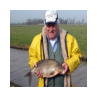

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def show_image(path):
    image = Image.open(path)
    image_resized = image.resize((224, 224))
    image_resized = np.array(image_resized)
    fig, ax = plt.subplots(figsize=(1,1))
    ax.imshow(image_resized)
    ax.axis('off')
    plt.show()

# choose nice image

for image_number, path_to_some_image in enumerate(all_explanations_filtered[0]['paths_original_images']):
    print(image_number, path_to_some_image)
    # show_image(all_explanations[0]['paths_only_explanation'][2])
    show_image(path_to_some_image)
    if image_number == 10:
        break

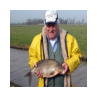

In [19]:
image_path = os.path.join(current_file_dir, "fake_dataset\\train\\n01440764\\n01440764_1185.JPEG")
show_image(image_path)

In [20]:
all_explanations_filtered[0].keys()

dict_keys(['explanations', 'paths', 'labels', 'model_name', 'explanation_name', 'predictions', 'paths_only_explanation', 'paths_original_images'])

# Plotting - for each image, plot all models and all explanations

### Filter all results to leave only a list of dicts containing a single explanation about given path

In [21]:
def filter_explanations(dict_of_explanations_from_model, original_image_path_to_be_filtered):
    # get index of path in the paths_original_images list
    index = dict_of_explanations_from_model['paths_original_images'].index(original_image_path_to_be_filtered)
    filtered_dict = {}

    # in all other lists in the dict, get the element with the same index
    for k, v in dict_of_explanations_from_model.items():
        try:
            if type(v) == str:
                raise Exception
            filtered_dict[k] = v[index]
        except:
            filtered_dict[k] = v
    return filtered_dict

def filter_all_explanations(all_explanations, image_path):
    return [filter_explanations(e, image_path) for e in all_explanations]

filter_explanations(all_explanations[0], image_path)

{'explanations': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0339, 0.0339, 0.0339],
         [0.0000, 0.0000, 0.0000,  ..., 0.0339, 0.0339, 0.0339],
         [0.0000, 0.0000, 0.0000,  ..., 0.0339, 0.0339, 0.0339]]),
 'paths': 't:\\studies\\py_projects\\master_thesis\\cnn-vs-transformers-msc-thesis\\results\\20240918-image-inpaining-example-fish\\fake_dataset_explanations\\imagenette2\\GradCAM\\ConvNeXtV2_Nano\\n01440764\\n01440764_1185.npy',
 'labels': tensor(0),
 'model_name': 'ConvNeXtV2_Nano',
 'explanation_name': 'GradCAM',
 'predictions': tensor(0),
 'paths_only_explanation': 't:\\studies\\py_projects\\master_thesis\\cnn-vs-transformers-msc-thesis\\results\\20240918-image-inpaining-example-fish\\fake_dataset_explanations\\imagenette2\\GradCAM\\ConvNeXtV2_Nano\\n01440764\\n014407

In [22]:
explanations_filtered = filter_all_explanations(all_explanations_filtered, image_path)

### Plotting function, saves the result to file named after original image filename

In [34]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import imagenette_classes_mapping

def get_class_codename_from_prediction(predicted_label):
    return imagenette_classes_mapping.imagenette2_id_to_class_mapping[predicted_label]

def get_class_name_from_prediction(predicted_label):
    return imagenette_classes_mapping.imagenette2_class_to_name_mapping[get_class_codename_from_prediction(predicted_label)]

def plot_comparison_of_explanations(explanations_filtered, output_suffix=None):

    explanation_to_title_mapping = {
        'GradCAM' : 'Grad-CAM',
        'IntegratedGradients' : 'Integrated\nGradients',
        'KernelSHAP' : 'KernelSHAP'
    }

    data = explanations_filtered
    
    # Extract unique models and explanation methods
    models = sorted(set(item['model_name'] for item in data))
    explanation_methods = sorted(set(item['explanation_name'] for item in data))

    # Create a dictionary to map (model, explanation) to the image path
    image_paths = {(item['model_name'], item['explanation_name']): item['paths_only_explanation'] for item in data}
    prediction_classes = {(item['model_name'], item['explanation_name']): get_class_name_from_prediction(item['predictions'].item()) for item in data}
    real_classes = get_class_name_from_prediction(data[0]['labels'].item())

    # Plotting the images
    fig, axes = plt.subplots(len(models)+1, len(explanation_methods), figsize=(4,13), dpi=300)

    # set 0th row with original image
    for i in range(len(explanation_methods)):
        ax = axes[0, i]
        ax.imshow(np.array(Image.open(data[0]['paths_original_images']).resize((224, 224))))
        ax.axis('off')
    axes[0, 0].axis('on')
    axes[0, 0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axes[0, 0].set_ylabel('Original Image' + '\n' + real_classes, rotation=0, labelpad=57)

    # set titles for each column as explanation method
    for i, explanation in enumerate(explanation_methods):
        axes[0, i].set_title(explanation_to_title_mapping[explanation], rotation=0, pad=0, fontsize=10)

    for i, model in enumerate(models):
        for j, explanation in enumerate(explanation_methods):
            ax = axes[i+1, j]
            image_path_1 = image_paths.get((model, explanation), None)

            if image_path_1 and os.path.exists(image_path_1):
                img = mpimg.imread(image_path_1)
                ax.imshow(img)
            else:
                ax.text(0.5, 0.5, 'No Image', ha='center', va='center', fontsize=12)
            
            # Set thin frame around the image
            for spine in ax.spines.values():
                spine.set_edgecolor('black')  # Color of the frame
                spine.set_linewidth(0.5)      # Thickness of the frame
            
            if j == 0:
                ax.set_ylabel(model.replace('_', ' ') + '\n' + utils.models_to_architecture_mapping[model] + '\n' + prediction_classes.get((model, explanation)), rotation=0, labelpad=50)
                # get y-axis label to be in the middle of the image
                ax.yaxis.set_label_coords(-0.8, 0.25)

            # Hide the ticks and labels
            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

            # Make sure the frame (spines) are visible
            ax.spines['top'].set_visible(True)
            ax.spines['bottom'].set_visible(True)
            ax.spines['left'].set_visible(True)
            ax.spines['right'].set_visible(True)

    # reduce space between subplots
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.01, wspace=0.01)

    output_filename_addition = data[0]['paths_original_images'].split('\\')[-1].replace('.JPEG', '')
    output_suffix = '' if output_suffix == None else f"_{output_suffix}"
    plt.savefig(f"explanations_{output_filename_addition}{output_suffix}.png", dpi=300)
    plt.close()

### Create and save all plots

A single test.

In [35]:
explanations_filtered = filter_all_explanations(all_explanations_filtered, image_path)
plot_comparison_of_explanations(explanations_filtered)

All images for which all models gave the same prediction.

In [36]:
import random
random.seed(42)
indices_order = list(range(len(all_explanations_filtered[0]['paths_original_images'])))
random.shuffle(indices_order)

for i in range(min(30, len(indices_order))):
    path_to_some_image = all_explanations_filtered[0]['paths_original_images'][indices_order[i]]
    print(path_to_some_image)
    plot_comparison_of_explanations(filter_all_explanations(all_explanations_filtered, path_to_some_image))

t:\studies\py_projects\master_thesis\cnn-vs-transformers-msc-thesis\results\20240918-image-inpaining-example-fish\fake_dataset\train\n01440764\n01440764_1185.JPEG


#### Also plots images where not all models have agreed

In [37]:
all_explanations_filtered_one_wrong = filter_images_where_at_least_one_model_was_wrong(all_explanations, all_agree=False)
len(all_explanations_filtered_one_wrong[0]['predictions'])

1

In [38]:
indices_order = list(range(len(all_explanations_filtered_one_wrong[0]['paths_original_images'])))
random.shuffle(indices_order)

for i in range(min(30, len(indices_order))):
    path_to_some_image = all_explanations_filtered_one_wrong[0]['paths_original_images'][indices_order[i]]
    print(path_to_some_image)
    plot_comparison_of_explanations(filter_all_explanations(all_explanations_filtered_one_wrong, path_to_some_image), output_suffix='not_all_correct')

t:\studies\py_projects\master_thesis\cnn-vs-transformers-msc-thesis\results\20240918-image-inpaining-example-fish\fake_dataset\train\n01440764\n01440764_1185_modified.JPEG
